In [1]:
# for data preprocessing
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import StandardScaler
# pour le visualisation
import seaborn as sns
import matplotlib.pyplot as plt
# model de performance 
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
#from sklearn.model_selection import layers, losses
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, precision_score, recall_score

In [2]:
ds = pd.read_excel('Dataset_final_Android.xlsx')

In [3]:
ds.shape

(2000, 7)

In [4]:
ds.columns

Index(['Date ', 'Heure ', 'id processus', 'id utilisateur',
       'niveau de priorite', 'le tag', 'message detailler'],
      dtype='object')

In [5]:
ds = ds[['id processus', 'id utilisateur', 'niveau de priorite', 'le tag', 'message detailler']]
ds.head()

,id processus,id utilisateur,niveau de priorite,le tag,message detailler
0,1702,2395,D,ActivityManager,printFreezingDisplayLogsopening app wtoken = A...
1,1702,8671,D,ActivityManager,"acquire lock=233570404, flags=0x1, tag=""View L..."
2,1702,8671,D,ActivityManager,"ready=true,policy=3,wakefulness=1,wksummary=0x..."
3,1702,2113,V,ActivityManager,WindowManager: Skipping AppWindowToken{df0798e...
4,2227,2227,D,ActivityManager,visible is system.time.showampm


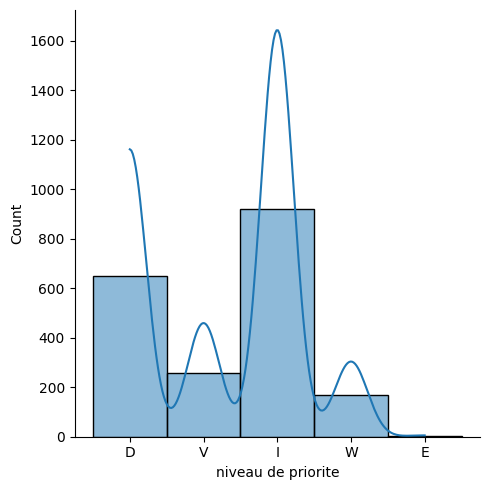

In [6]:
sns.displot(data=ds, x='niveau de priorite', kde=True)

In [7]:
ds[ds['niveau de priorite'] == 'E']

,id processus,id utilisateur,niveau de priorite,le tag,message detailler
198,2227,2794,E,PhoneStatusBar,isSimPinSecure mSimDatas is null or empty
233,1702,17633,E,ActivityManager,applyOptionsLocked: Unknown animationType=0
1964,1702,2639,E,ActivityManager,applyOptionsLocked: Unknown animationType=0


In [8]:
dataset_non_numerique = []
for k,v in zip(ds.columns,ds.dtypes):
    if v=="object":
        dataset_non_numerique.append(k)

In [9]:
numerisation = {colonne:{v:k for k,v in enumerate(ds[colonne].unique())}
for colonne in dataset_non_numerique}

In [10]:
#numerisation

In [11]:
for colonne in dataset_non_numerique:
    ds[colonne]= ds[colonne].map(numerisation[colonne])

array([[<Axes: title={'center': 'id processus'}>,
        <Axes: title={'center': 'id utilisateur'}>],
       [<Axes: title={'center': 'niveau de priorite'}>,
        <Axes: title={'center': 'le tag'}>],
       [<Axes: title={'center': 'message detailler'}>, <Axes: >]],
      dtype=object)

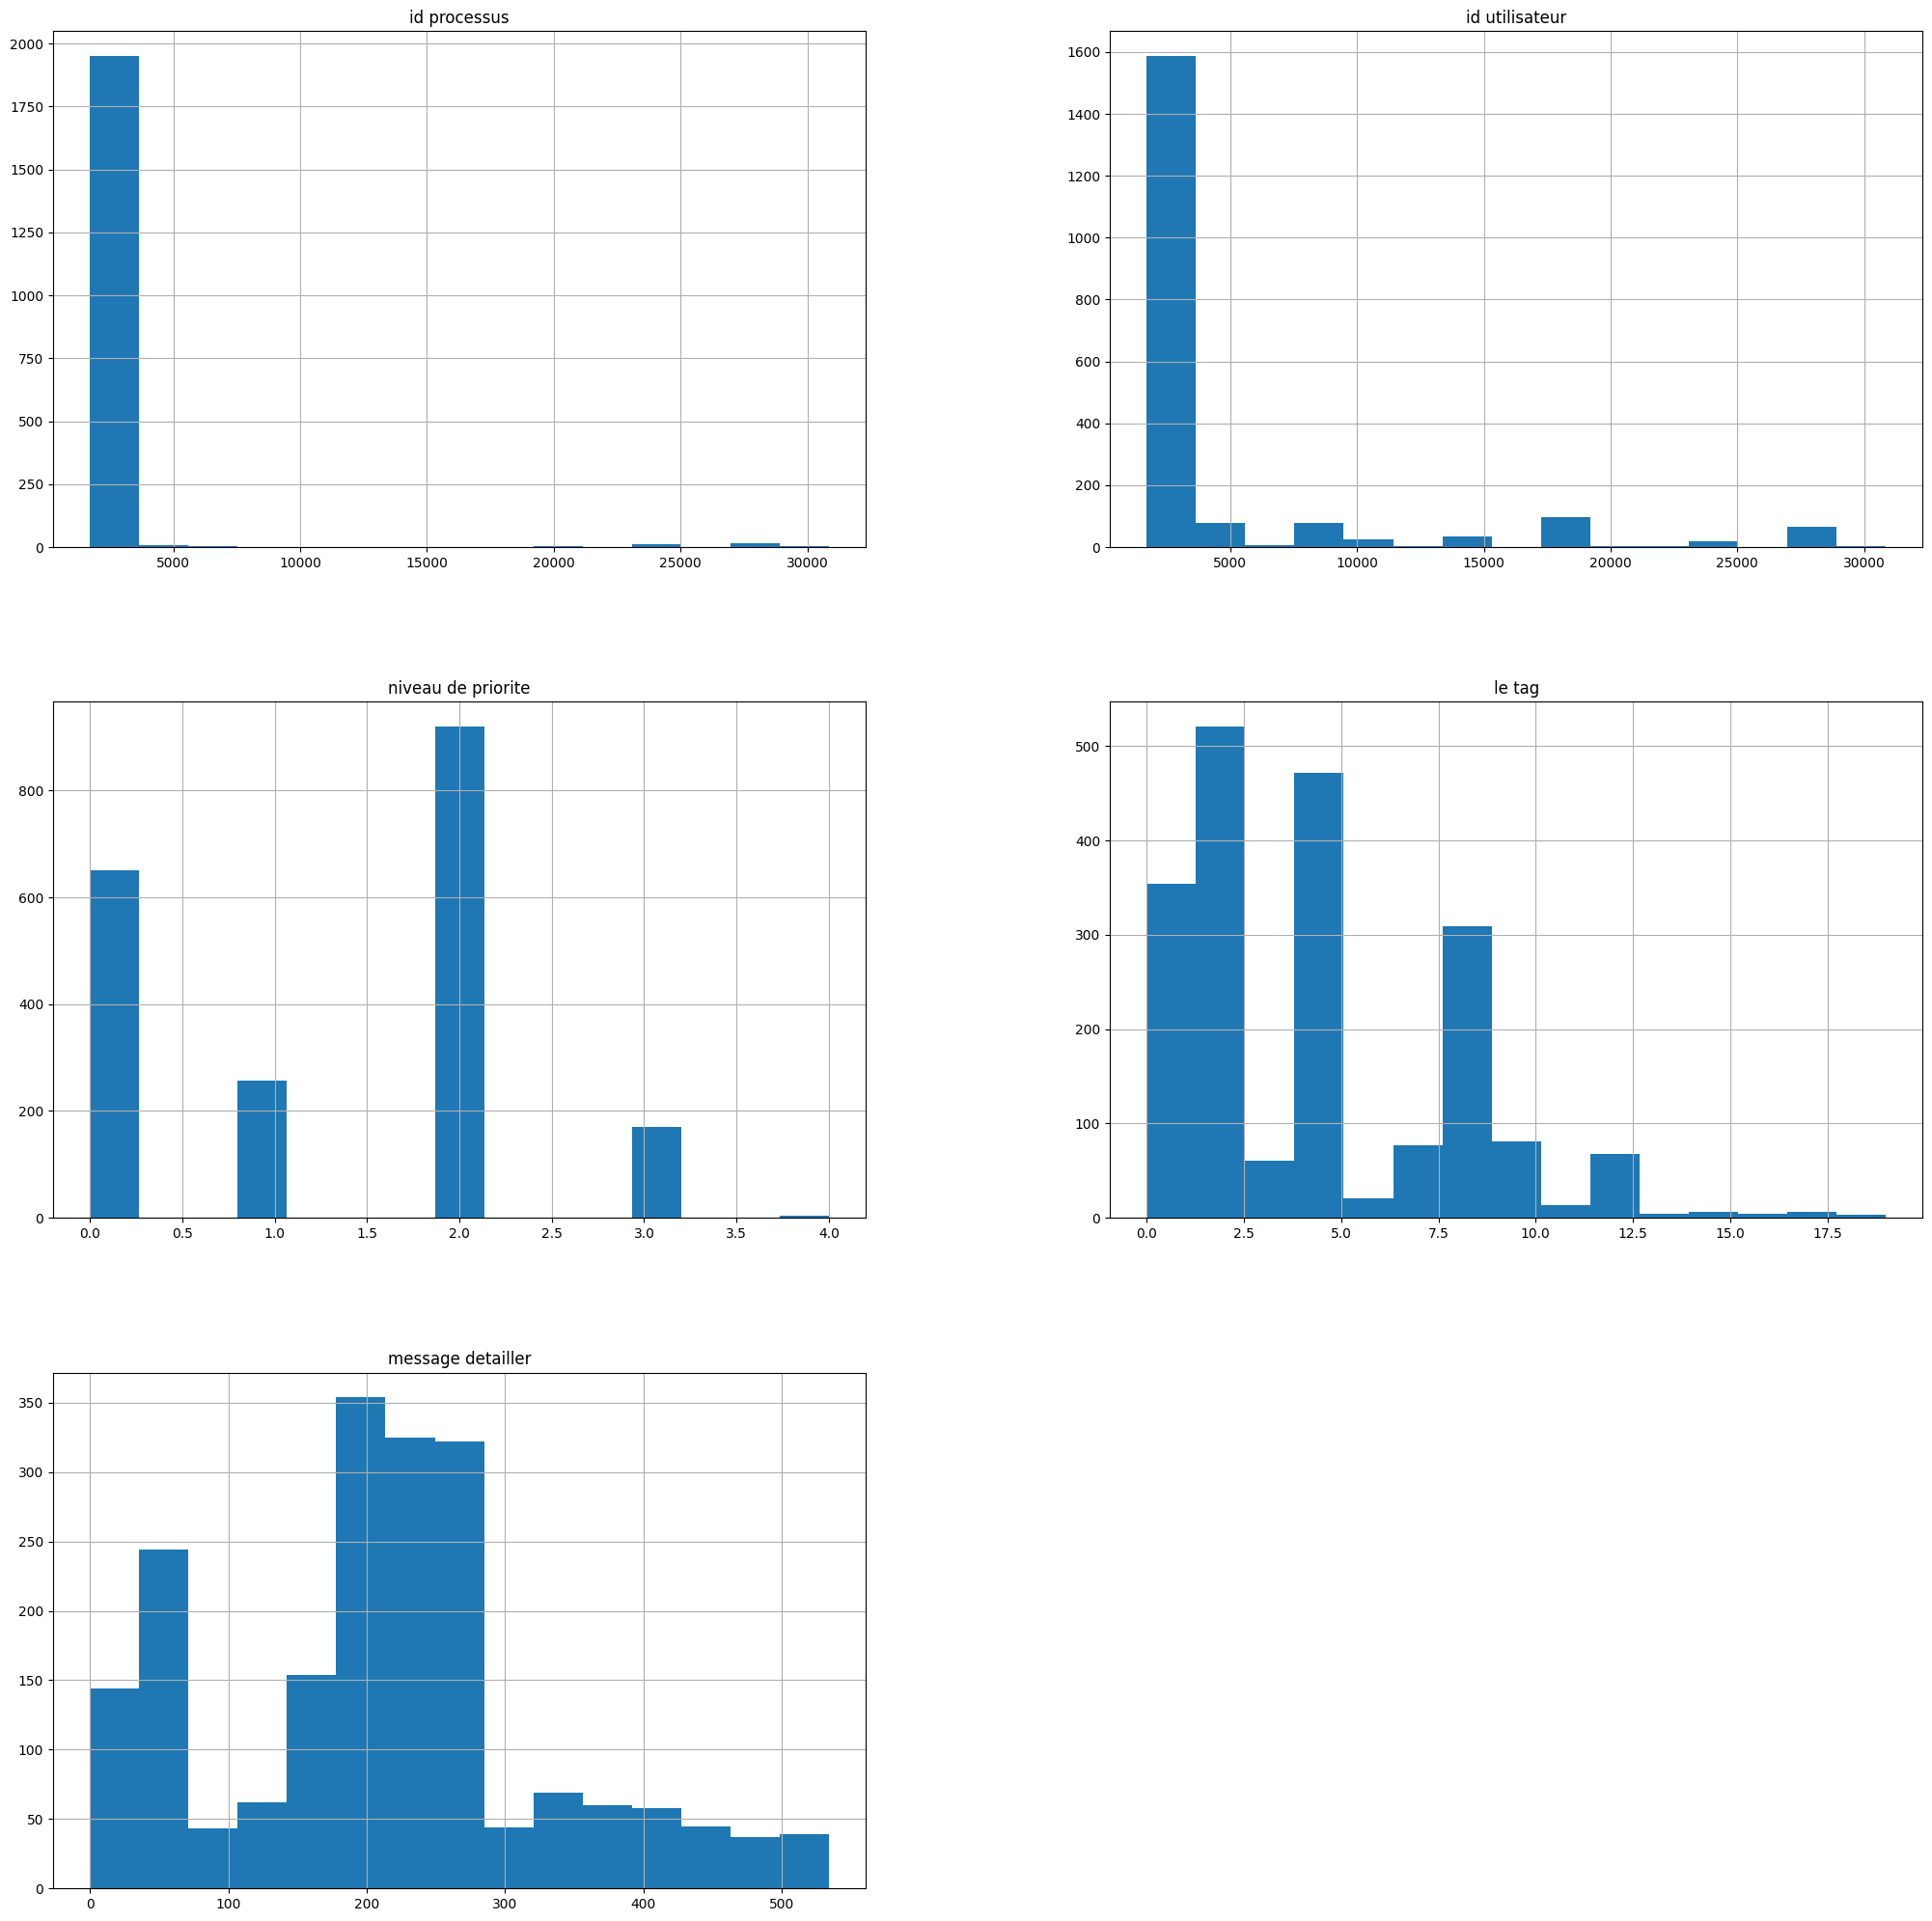

In [12]:
list_colonne = []
for k,v in zip(ds.columns,ds.dtypes):
    list_colonne.append(k)
ds[list_colonne].hist(bins=15, figsize=(25,25))

In [13]:
ds['niveau de priorite'].unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [14]:
ds.describe()

,id processus,id utilisateur,niveau de priorite,le tag,message detailler
count,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000
mean,2387.33550,4703.915500,1.309500,4.230500,209.070000
std,3225.42582,6201.728915,1.021387,3.415729,119.856727
min,1702.00000,1702.000000,0.000000,0.000000,0.000000
25%,1702.00000,2105.000000,0.000000,2.000000,143.000000
50%,1702.00000,2227.000000,2.000000,4.000000,212.500000
75%,2227.00000,2644.000000,2.000000,7.000000,258.000000
max,30852.00000,30852.000000,4.000000,19.000000,534.000000


In [15]:
y = ds['niveau de priorite']
x = ds.drop(['niveau de priorite'], axis=1)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=111)

In [17]:
x_train.head()

,id processus,id utilisateur,le tag,message detailler
1696,2227,2227,8,475
455,2227,2227,9,194
1431,1702,2105,2,439
132,2227,2227,4,81
1029,1702,1820,4,217


In [18]:
scaler = StandardScaler()
data_scaled = scaler.fit(x_train)
data_scaled = scaler.fit(x_test)
train_data_scaled = data_scaled.transform(x_train)
test_data_scaled = data_scaled.transform(x_test)

In [19]:
x_train[['ID_PROC','ID_USER','TAG','MSG_DETAIL']] = train_data_scaled
x_test[['ID_PROC','ID_USER','TAG','MSG_DETAIL']] = test_data_scaled
x_train = x_train.iloc[:,4:]
x_test = x_test.iloc[:,4:]

In [20]:
x_train.shape

(1600, 4)

In [21]:
x_test.shape

(400, 4)

In [22]:
normal_train_data = x_train[(y_train != 4)]
anomaly_train_data = x_train[(y_train == 4)]
normal_test_data = x_test[(y_test != 4)]
anomaly_test_data = x_test[(y_test == 4)]

In [23]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    # Input layer
    input = tf.keras.layers.Input(shape=(4,))
    self.encoder = tf.keras.Sequential([
      Dense(2, activation="relu"),
      Dense(1, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      Dense(2, activation="relu"),
      Dense(4, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [24]:
# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mae')
# Fit the autoencoder
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=200,
          batch_size=20,
          validation_data=(x_test, x_test),
          shuffle=True)

Epoch 1/200
80/80 [==============================] - 1s 5ms/step - loss: 0.8724 - val_loss: 0.8438
Epoch 2/200
80/80 [==============================] - 0s 2ms/step - loss: 0.8295 - val_loss: 0.7941
Epoch 3/200
80/80 [==============================] - 0s 2ms/step - loss: 0.7774 - val_loss: 0.7395
Epoch 4/200
80/80 [==============================] - 0s 2ms/step - loss: 0.7256 - val_loss: 0.6926
Epoch 5/200
80/80 [==============================] - 0s 2ms/step - loss: 0.6850 - val_loss: 0.6598
Epoch 6/200
80/80 [==============================] - 0s 2ms/step - loss: 0.6593 - val_loss: 0.6413
Epoch 7/200
80/80 [==============================] - 0s 3ms/step - loss: 0.6438 - val_loss: 0.6299
Epoch 8/200
80/80 [==============================] - 0s 2ms/step - loss: 0.6341 - val_loss: 0.6229
Epoch 9/200
80/80 [==============================] - 0s 2ms/step - loss: 0.6279 - val_loss: 0.6183
Epoch 10/200
80/80 [==============================] - 0s 2ms/step - loss: 0.6233 - val_loss: 0.6150
Epoch 11/

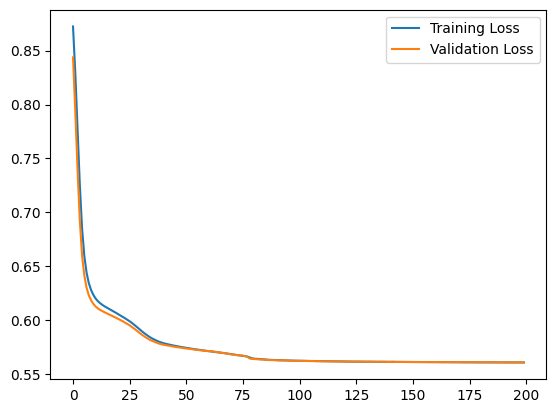

In [25]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [26]:
#encoded_data = autoencoder.encoder(normal_test_data)
#decoded_data = autoencoder.decoder(encoded_data)
#normal_test_data

In [27]:
#plt.plot(normal_test_data.iloc[:0,1], 'b')
#plt.plot(decoded_data.iloc[:,0:1], 'r')
#plt.fill_between(np.arange(4), decoded_data[0], normal_test_data.iloc[:0,1], color='lightcoral')
#plt.legend(labels=["Input", "Reconstruction", "Error"])
#plt.show()

13/13 [==============================] - 0s 2ms/step
The prediction loss threshold for 2% of outliers is 1.64


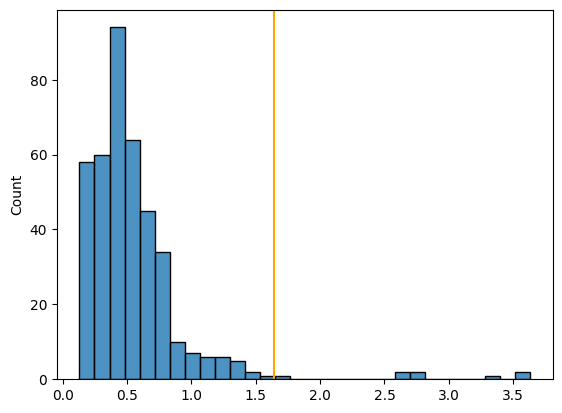

In [28]:
# for predict anomalies/outliers in the training dataset
prediction = autoencoder.predict(x_test)
# for get the mean absolute error between actual and reconstruction/prediction
prediction_loss = tf.keras.losses.mae(prediction, x_test)
# for check the prediction loss threshold for 2% of outliers
loss_threshold = np.percentile(prediction_loss, 98)
print(f'The prediction loss threshold for 2% of outliers is {loss_threshold:.2f}')
# for visualize the threshold
sns.histplot(prediction_loss, bins=30, alpha=0.8)
plt.axvline(x=loss_threshold, color='orange')

In [29]:
# for control the model performance at 2% threshold
threshold_prediction = [0 if i < loss_threshold else 1 for i in prediction_loss]
# for control the prediction performance
print(classification_report(y_test, threshold_prediction))

              precision    recall  f1-score   support

           0       0.35      0.99      0.52       139
           1       0.88      0.11      0.20        61
           2       0.00      0.00      0.00       164
           3       0.00      0.00      0.00        36

    accuracy                           0.36       400
   macro avg       0.31      0.28      0.18       400
weighted avg       0.26      0.36      0.21       400



C:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier